In [1]:
# %matplotlib
import numpy as np
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("../output/moon.jpg")
im_tmp = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

kernel = np.ones((5,5))
img = cv2.erode(img, kernel, iterations=1)
plt.imshow(img, cmap="gray")

isBlackG = lambda pix: (pix < 10)
isBlack = lambda pix: (pix[0] == 0 and pix[1] == 0 and pix[2] == 0)

In [3]:
def floodfunc(img, x, y, visited, mask, iterations, max_iterations=40):
    if iterations < max_iterations:
        
        visited[x][y] = 1
        mask[x][y] = 1

        if x+1 < img.shape[0] and not isBlackG(img[x+1][y]) and visited[x+1][y]==0:
            mask = floodfunc(img, x+1, y, visited, mask, iterations+1, max_iterations)

        if y+1 < img.shape[1] and not isBlackG(img[x][y+1]) and visited[x][y+1]==0:
            mask = floodfunc(img, x, y+1, visited, mask, iterations+1, max_iterations)

        if x-1 >= 0 and not isBlackG(img[x-1][y]) and visited[x-1][y]==0:
            mask = floodfunc(img, x-1, y, visited, mask, iterations+1, max_iterations)

        if y-1 >= 0 and not isBlackG(img[x][y-1]) and visited[x][y-1]==0:
            mask = floodfunc(img, x, y-1, visited, mask, iterations+1, max_iterations)
        
    return mask

In [4]:
def func(x,y,visited, m, img):
    visited[x][y] = 1
    m.append((x,y))
    
    if x+1< img.shape[0] and isBlackG(img[x+1][y]) and visited[x+1][y]==0:
        visited,m = func(x+1,y,visited, m, img)

    if y+1< img.shape[1] and isBlackG(img[x][y+1]) and visited[x][y+1]==0:
        visited,m = func(x,y+1, visited, m, img)
    
    if x-1>=0 and isBlackG(img[x-1][y]) and visited[x-1][y]==0:
        visited,m = func(x-1,y, visited, m, img)
    
    if y-1>=0 and isBlackG(img[x][y-1]) and visited[x][y-1]==0:
        visited,m = func(x,y-1, visited, m, img)
    
    return visited,m

In [5]:
vector = []
visited = np.zeros_like(img)
height   = img.shape[0]
width    = img.shape[1]

# print(height, width)
i = 0
j = 0
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if isBlackG(img[i][j]):
            m = []
            v = np.array(m)
            visited, v = func(i, j, visited, m, img)
#             print(v)
            if len(v)>=100:
                vector.append(m)

    

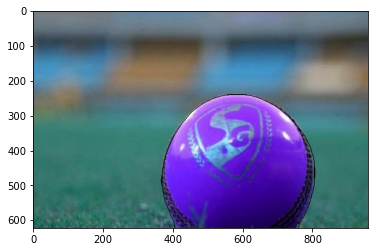

In [6]:
validPt = lambda im, i, j: i>=0 and j>=0 and i<im.shape[0] and j<im.shape[1]

def markPts(im, x, y, th=2):
    out = np.copy(im)
    for i in range(x-th//2, x-th//2+th):
        for j in range(y-th//2, y-th//2+th):
            if validPt(im, i, j):
                out[i][j][0] = 255
                out[i][j][1] = 255
                out[i][j][2] = 255
    return out

img_cpy = np.copy(im_tmp)
mask = np.zeros_like(img)
visited = np.zeros_like(img)

for i in vector:
    for j in i:
#         img_cpy = markPts(img_cpy, j[0], j[1])
        mask = floodfunc(img, j[0], j[1], visited, mask, 0)

# img_cpy[mask==1] = [255]
plt.imshow(img_cpy)

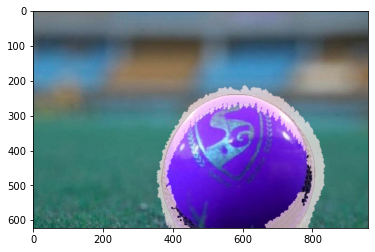

In [7]:
img_marked = np.copy(img_cpy)

for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        if mask[i][j] == 1:
            img_marked[i][j][0] = img_marked[i][j][0] + 50 if img_marked[i][j][0] < 205 else 255
#             img_cpy[i][j][1] = 0
#             img_cpy[i][j][2] = 0

b_channel, g_channel, r_channel = cv2.split(img_marked)

alpha_channel = np.zeros(b_channel.shape, dtype=b_channel.dtype)
alpha_channel[mask==1] = 100
alpha_channel[mask!=1] = 255

img_BGRA = cv2.merge((b_channel, g_channel, r_channel, alpha_channel))

plt.imshow(img_BGRA)

In [ ]:
cv2.imwrite("../output/moon_cs.jpg", img_BGRA)